In [1]:
import bilby
import os
import glob
import numpy as np
from scipy import interpolate
import utilizes_plot

mrms_data_label=['ns_obs','ana_corrected_mrms_87','phe_corrected_mrms_87','ana_corrected_mr_53','phe_corrected_mr_53','mr_obs_53','ms_34']
############# j=   0                1                       2                      3                       4                  5      6
sub_model_name_list=['turn_on_pow','turn_on_pow_fix','turn_on_pow_G','pow', '2G','turn_on_pow_G_fixed_max','G','2G_fixed_max', 'sst', 'G_fixed_max', '2G_fixed_min','2G_fixed_max_min','logu','3G_fixed_max_min','lognorm','gamma', 'U','G_fixed_max_min']
############ i=           0(4)       1(3)                2(7)         3(3)   4(7)            5(6)          6(4)       7(6)     8(4)        9(3)            10(6)              11(5)     12(2)      13(8)           14(2)    15(2)  16(2)      17(2)   
data_name_labes=[r'$\rm{OBS}$',r'$\rm{ANA}$',r'$\rm{PHE}$',r'$\rm{ANA_{m_r}}$',r'$\rm{PHE_{m_r}}$',r'$\rm{m_r}$',r'$\rm{m_s}$']
model_name_label=[r'$\rm{TOP}$',r'$\rm{TOP_{min}}$',r'$\rm{TOPG}$',r'$\rm{POW}$',r'$\rm{2G^{max}_{min}}$',r'$\rm{TOPG_{min}}$',r'$\rm{G^{max}_{min}}$',r'$\rm{2G_{min}}$',r'$\rm{SST}$',r'$\rm{G_{min}}$',r'$\rm{2G_{max}}$',r'$\rm{2G}$',r'$\rm{LogU}$',r'$\rm{3G}$',r'$\rm{LogN}$',r'$\rm{Gamma}$',r'$\rm{U}$',r'$\rm{G}$']
###########

def HDI(xx,yy,ci):
    f0 = interpolate.interp1d(xx, yy, bounds_error=False, fill_value=0)
    samp_max=np.max(xx)
    samp_min=np.min(xx)
    def norm_p(x):
        
        a=np.linspace(samp_min,samp_max,1000)
        return f0(x)/np.trapz(f0(a),a)
    dx=np.linspace(samp_min,samp_max,1000)
    dy=norm_p(dx)
    Tstep=np.diff(dx)[0]
    posterior_m1= dy
    sort_p = np.sort(posterior_m1)[::-1]
    sort_parg = np.argsort(posterior_m1)[::-1]
# compute accumulate probability, save critical index
    cdf, confidence_level = 0, ci
    for k in range(0, len(sort_p)):
        if cdf <= confidence_level:
            cdf += sort_p[k]*Tstep
        else:
            index = k
            break
    # find the boundary, i.e. 1 ci%_low 2 peak 3 ci%_high
    return np.min(dx[sort_parg[:index]]),  dx[sort_parg[0]], np.max(dx[sort_parg[:index]])

i=0
mii=np.linspace(0.7,3,400)
post_data_model_top={}
for j in [1,2,0]:
    main_direct='/home/yzq/Documents/NS_mass/BNU/NS_mass/NS_sci/NS_mass_2023/'
    os.path.exists(main_direct+'{}/{}/hy_outdir/*.json'.format(mrms_data_label[j],sub_model_name_list[i]) )
    fnames= glob.glob( main_direct+'{}/{}/hy_outdir/*.json'.format(mrms_data_label[j],sub_model_name_list[i])  )
    fname=fnames[0]
    re=bilby.result.read_in_result( fname )
    temp_post=((re.posterior).iloc[:,0:-2]).values 
    post_data_model_top["post_"+str(mrms_data_label[j])+'_'+str(sub_model_name_list[i])]=temp_post
    
    peak_te=np.zeros(len(post_data_model_top["post_"+str(mrms_data_label[j])+'_'+str(sub_model_name_list[i])]) ) 
    for k in range(len(post_data_model_top["post_"+str(mrms_data_label[j])+'_'+str(sub_model_name_list[i])])):
        post_tem=post_data_model_top["post_"+str(mrms_data_label[j])+'_'+str(sub_model_name_list[i])]
        mass_model=eval('utilizes_plot.hyper_prior_{}'.format(sub_model_name_list[i]) )
        model_curve_yi=mass_model(mii,post_tem[k,0],post_tem[k,1],post_tem[k,2],post_tem[k,3])
        peak_te[k]=HDI(mii,model_curve_yi,0.9)[1] 
    post_data_model_top["post_"+str(mrms_data_label[j])+'_'+str(sub_model_name_list[i])]=np.insert(post_tem,4,peak_te,axis=1)

In [2]:
ana_pos_sam=post_data_model_top["post_"+str(mrms_data_label[1])+'_'+str(sub_model_name_list[0])]
phe_pos_sam=post_data_model_top["post_"+str(mrms_data_label[2])+'_'+str(sub_model_name_list[0])]
obs_pos_sam=post_data_model_top["post_"+str(mrms_data_label[0])+'_'+str(sub_model_name_list[0])]

In [3]:
data_obs_ana=list()
data_obs_ana.append(obs_pos_sam[:,[1,3,2,0]])
data_obs_ana.append(ana_pos_sam[:,[1,3,2,0]])

In [5]:
import numpy as np
import os
import glob
import pandas as pd
parent_dir_path=os.path.abspath( os.path.join(os.getcwd(),'..')) 

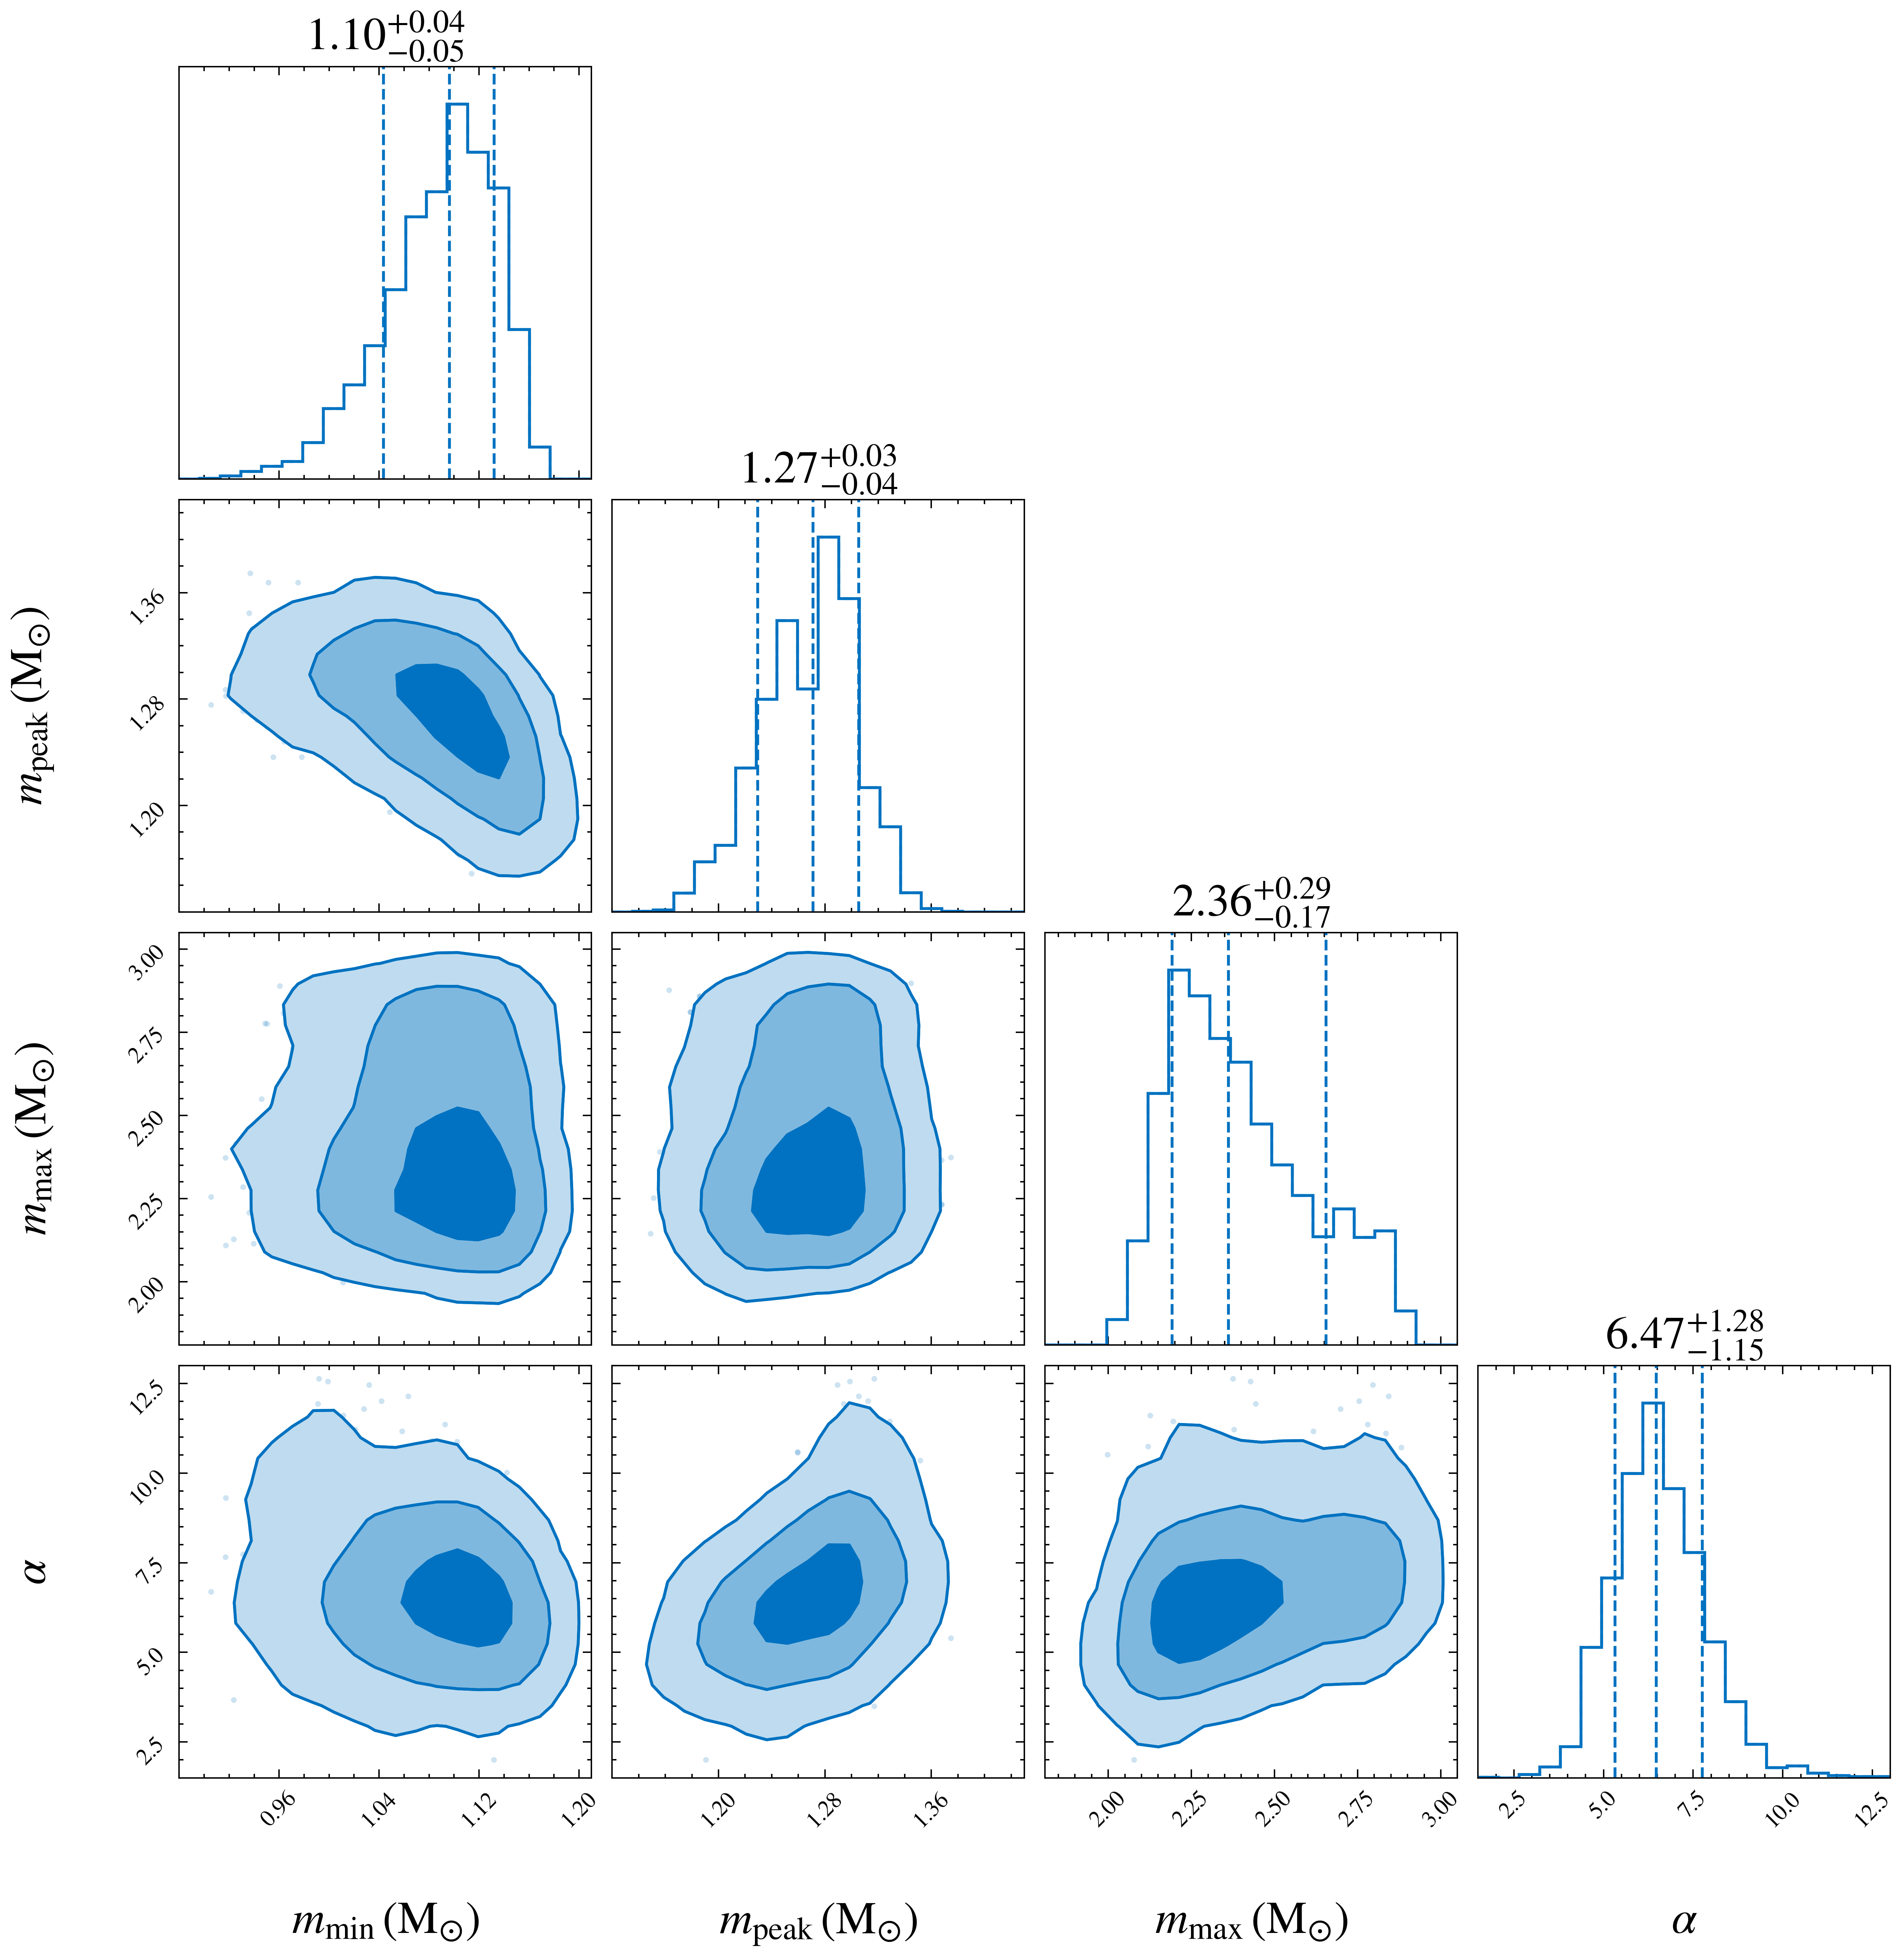

In [6]:
import corner.corner
import scienceplots
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
%matplotlib inline
plt.style.use(['science','ieee','no-latex'])

def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)

ana_pos_sam=post_data_model_top["post_"+str(mrms_data_label[1])+'_'+str(sub_model_name_list[0])]
phe_pos_sam=post_data_model_top["post_"+str(mrms_data_label[2])+'_'+str(sub_model_name_list[0])]

max_len=max(len(ana_pos_sam),len(ana_pos_sam) )
#ranges=([0.88,1.21],[1.11,1.38],[1.9,3.05],[2,13])
ranges=([0.88,1.21],[1.12,1.43],[1.81,3.05],[1.5,13])
fig= corner.corner(ana_pos_sam[:,[1,4,2,0]], 
                       bins=20,smooth=0.9,color='#0072c1', #blue_line
                       labels=[r'$m_{\rm{min}}\,({\rm {M_{\odot}}} )  $',r'$ m_{\rm{\rm peak}} \,({\rm {M_{\odot}}} ) $',r'$ m_{\rm{\rm max}} \,({\rm {M_{\odot}}} ) $',r'$\alpha$'],
                       #quantiles=[0.16, 0.5, 0.84],
                       levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                       #weights=get_normalisation_weight(len(ana_pos_sam), max_len),
                       plot_density=False, plot_datapoints=True, fill_contours=True,
                       label_kwargs=dict(fontsize=16),range=ranges,
                       show_titles=0, title_kwargs={"fontsize": 16})
corner.corner(ana_pos_sam[:,[1,4,2,0]],
                       bins=20,smooth=0.9,color='#0072c1',appha=0,
                       #labels=[r'$m_{\rm{min}} $',r'$ m_{\rm{\rm peak}}  $',r'$\alpha$'],
                       quantiles=[0.16, 0.5,0.84],
                       levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                       #weights=get_normalisation_weight(len(phe_pos_sam), max_len),
                       plot_density=False, plot_datapoints=True, fill_contours=True,
                       label_kwargs=dict(fontsize=16),range=ranges,
                       show_titles=True, title_kwargs={"fontsize": 16,"color":'black'},fig=fig)


blue_line = mlines.Line2D([],[],color='#0072c1', lw=2,label=r'$\rm{ANA}$')
#orange_line= mlines.Line2D([],[],color='#ff7f0e',lw=2,label=r'$\rm{PHE}$')

#plt.legend(handles=[blue_line],bbox_to_anchor=(1,3.2),loc='upper right',fontsize=16)#prop={'size': 8})

plt.savefig(parent_dir_path+'/figures/figure4.pdf')
plt.show()

In [8]:
np.savetxt('data_for_figure4.txt',ana_pos_sam[:,[1,4,2,0]])